# DETECCION DE MOVIMIENTO

In [41]:
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
 
# Compute the frame difference 
def frame_diff(prev_frame, cur_frame, next_frame): 
    # Absolute difference between current frame and next frame 
    diff_frames1 = cv2.absdiff(next_frame, cur_frame) 
 
    # Absolute difference between current frame and 
     # previous frame 
    diff_frames2 = cv2.absdiff(cur_frame, prev_frame) 
 
    # Return the result of bitwise 'AND' between the 
     # above two resultant images 
    return cv2.bitwise_and(diff_frames1, diff_frames2) 
 
# Capture the frame from webcam 
def get_frame(cap, scaling_factor): 
    # Capture the frame 
    ret, frame = cap.read() 
 
    # Resize the image 
    frame = cv2.resize(frame, None, fx=scaling_factor, 
            fy=scaling_factor, interpolation=cv2.INTER_AREA) 
 
    return frame
 
if __name__=='__main__': 
    cap = cv2.VideoCapture(0)  
    scaling_factor = 0.5
 
    cur_frame, prev_frame, next_frame = None, None, None
    while True:
        frame = get_frame(cap, scaling_factor)
        prev_frame = cur_frame 
        cur_frame = next_frame
        # Convert frame to grayscale image 
        next_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        if prev_frame is not None:
            cv2.imshow("Object Movement", frame_diff(prev_frame, cur_frame, next_frame)) 

        key = cv2.waitKey(delay=10) 
        if key == 27: 
            break 
 
    cv2.destroyAllWindows() 

# DETECCION DE MOVIMIENTO MOG

In [1]:
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
    import cv2
except:
    import cv2
import numpy as np 
 
# Capture the input frame 
def get_frame(cap, scaling_factor=0.5): 
    ret, frame = cap.read() 
 
    # Resize the frame 
    frame = cv2.resize(frame, None, fx=scaling_factor, 
            fy=scaling_factor, interpolation=cv2.INTER_AREA) 
 
    return frame 
 
if __name__=='__main__': 
    # Initialize the video capture object 
    cap = cv2.VideoCapture(0) 
 
    # Create the background subtractor object 
    bgSubtractor = cv2.createBackgroundSubtractorMOG2()
 
    # This factor controls the learning rate of the algorithm. 
    # The learning rate refers to the rate at which your model 
    # will learn about the background. Higher value for 
    # 'history' indicates a slower learning rate. You 
    # can play with this parameter to see how it affects 
    # the output. 
    history = 500 
 
    # Iterate until the user presses the ESC key 
    while True: 
        frame = get_frame(cap,1) 
 
        # Apply the background subtraction model to the input frame        
        mask = bgSubtractor.apply(frame, learningRate=1.0/history)
 
        # Convert from grayscale to 3-channel RGB 
        mask = mask>0
        mask = np.array(mask*255,np.uint8)
        kernel = np.ones((2,2), np.uint8) 
        mask = cv2.erode(mask, kernel, iterations=1) 
        mask = cv2.dilate(mask, kernel, iterations=1) 
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        #mask = np.array(mask,np.uint8)
        tmr = mask & frame
        mask[:,:,0] = (mask[:,:,0]<255)*120
        mask[:,:,1] = (mask[:,:,1]<255)*255
        mask[:,:,2] = (mask[:,:,2]<255)*120
        tmr = np.array(tmr+mask,np.uint8)
        cv2.imshow('Original', frame)
        cv2.imshow('Movimiento',tmr )
 
        # Check if the user pressed the ESC key 
        c = cv2.waitKey(delay=30) 
        if c == 27: 
            break 
 
    cap.release() 
    cv2.destroyAllWindows() 

# VECTOR GRADIENTE

##### El vector de gradiente de la imagen se define como una métrica para cada píxel individual, que contiene los cambios de color del píxel tanto en el eje x como en el eje y. La definición está alineada con el gradiente de una función multivariable continua, que es un vector de derivados parciales de todas las variables. Supongamos que f(x, y) registra el color del píxel en la ubicación (x, y), el vector de gradiente del píxel (x, y) se define de la siguiente manera:


\begin{align*}
\nabla f(x, y)
= \begin{bmatrix}
  g_x \\
  g_y
\end{bmatrix}
= \begin{bmatrix}
  \frac{\partial f}{\partial x} \\[6pt]
  \frac{\partial f}{\partial y}
\end{bmatrix}
= \begin{bmatrix}
  f(x+1, y) - f(x-1, y)\\
  f(x, y+1) - f(x, y-1)
\end{bmatrix}
\end{align*}

 ##### El término $\frac{\partial f}{\partial x}$ es la derivada parcial en la dirección x, que se calcula como la diferencia de color entre los píxeles adyacentes a la izquierda y a la derecha del objetivo, f(x+1, y) - f(x-1, y). De manera similar, el término $\frac{\partial f}{\partial y}$ es la derivada parcial en la dirección y, medida como f(x, y+1) - f(x, y-1), la diferencia de color entre los píxeles adyacentes por encima y por debajo del objetivo.

##### Hay dos atributos importantes de un gradiente de imagen:

- La magnitud es la norma L2 del vector, $g = \sqrt{ g_x^2 + g_y^2 }$.
- Dirección es el arctangente de la relación entre las derivadas parciales en dos direcciones, $\theta = \arctan{(g_y / g_x)}$.

### Kernels

##### 
- *Operador Prewitt* :
        En lugar de depender solo de cuatro vecinos directamente adyacentes, el operador Prewitt utiliza ocho píxeles circundantes para obtener resultados más uniformes.
        
\begin{align*}
% <![CDATA[
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-1 & 0 & +1 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +1 & +1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix} \ast \mathbf{A} %]]>
\end{align*}

-  Operador Sobel : 
        Para enfatizar más el impacto de los píxeles directamente adyacentes, se les asigna un mayor peso.

\begin{align*}
% <![CDATA[
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} \ast \mathbf{A} %]]>
\end{align*}


In [1]:
#!pip install scipy==1.1.0
#!pip install pillow
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as sig
import cv2
%matplotlib inline  

plt.rcParams['figure.figsize'] = [20,5]
import warnings
warnings.filterwarnings('ignore')

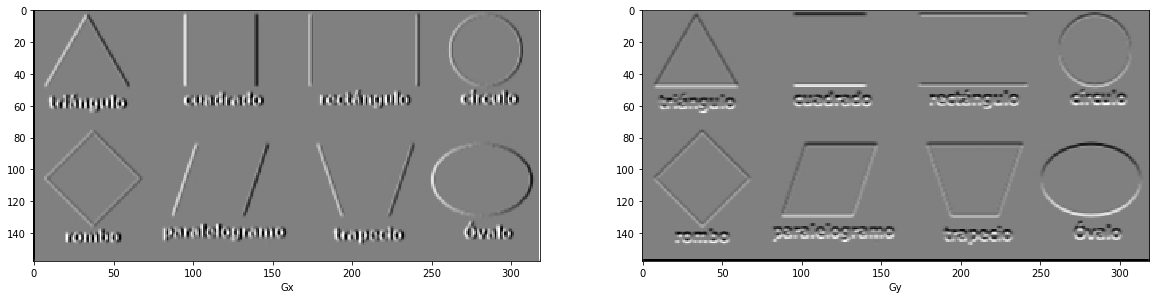

In [2]:
img = scipy.misc.imread("figuras.png", mode="L")

kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

G_x = sig.convolve2d(img, kernel_x, mode='same') 
G_y = sig.convolve2d(img, kernel_y, mode='same') 

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(G_x, cmap='gray'); ax1.set_xlabel("Gx")
ax2.imshow(G_y, cmap='gray'); ax2.set_xlabel("Gy")
plt.show()

## Detección de esquinas

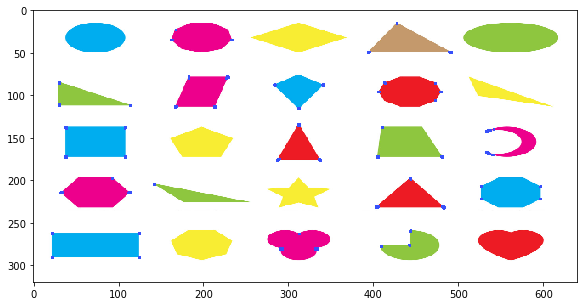

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
filename = 'figuras-geometricas.jpg'
#filename = 'figuras.png'
img = cv2.imread(filename)
img = cv2.resize(img,(640,320))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[250,80,55]

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Histograma de gradientes orientados (HOG)


In [4]:
!pip install scikit-image

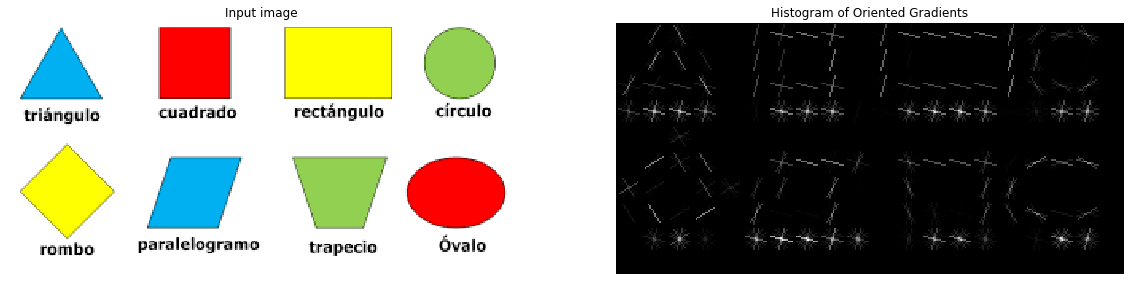

In [5]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = plt.imread('figuras.png')

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


Cómo funciona HOG

    1) Preprocese la imagen, incluido el cambio de tamaño y la normalización del color.

    2) Calcule el vector de gradiente de cada píxel, así como su magnitud y dirección.

    3) Divida la imagen en muchas celdas de 8x8 píxeles. En cada celda, los valores de magnitud de estas 64 celdas se agrupan y se agregan acumulativamente en 9 cubos de dirección sin signo (sin signo, por lo que 0-180 grados en lugar de 0-360 grados; esta es una opción práctica basada en experimentos empíricos).

Para una mejor robustez, si la dirección del vector de gradiente de un píxel se encuentra entre dos cubos, su magnitud no se acerca al más cercano, sino que se divide proporcionalmente entre dos. Por ejemplo, si el vector de gradiente de un píxel tiene magnitud 8 y grado 15, se encuentra entre dos cubos para el grado 0 y 20 y asignaríamos 2 al cubo 0 y 6 al cubo 20.

Esta configuración interesante hace que el histograma sea mucho más estable cuando es pequeño Se aplica distorsión a la imagen.

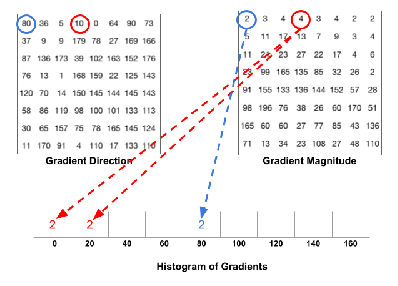

In [6]:
img = plt.imread('HOG-example.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## Scale Invariant Feature Transform

##### Es un método para extraer vectores de características que describen parches locales de una imagen. Estos vectores de características no solo son invariables en escala, sino que también son invariables para la traslación, rotación e iluminación.

    - Escala-Espacio Detección Extrema
    - Localización de puntos clave
    - Asignación de orientación
    - Creación de descriptores locales



### Escala-Espacio Detección Extrema

    La escala característica de un rasgo se puede detectar usando un filtro laplaciano-de-Gaussiano (LoG) normalizado en escala. Así es como se ve el filtro LoG:
    

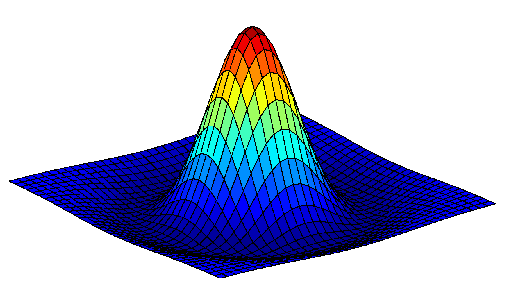

In [18]:
img = plt.imread('GAUS.png')
plt.imshow(img)
plt.axis('off')
plt.show()

El filtro LoG tiene un alto pico en el centro mientras se vuelve ligeramente negativo y luego cero a una distancia del centro caracterizado por la desviación estándar, sigma, del gaussiano.
Por lo tanto, el filtro LoG se activa más altamente por un círculo, o blob, con radio proporcional a sigma. Sin embargo, el gaussiano está normalizado, es decir, si lo integra en todo el espacio, se suma a uno. Por lo tanto, con un sigma más alto y, por lo tanto, un gaussiano más amplio, la respuesta del filtro LoG para ese gaussiano será menor que para un sigma más pequeño. Por lo tanto, SIFT utiliza el filtro LoG normalizado de escala, que es el LoG normal multiplicado por la varianza (sigma al cuadrado).


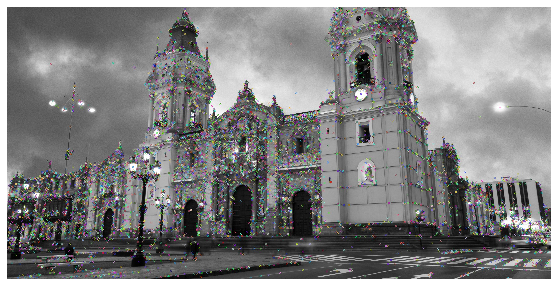

In [24]:
import cv2
import numpy as np

img = cv2.imread('IGLESIA.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp, outImage = None)#, color=(255,0,0))

cv2.imwrite('sift_keypoints.jpg',img)

img = plt.imread('sift_keypoints.jpg')
plt.imshow(img)
plt.axis('off')

plt.show()

In [25]:
# SURF

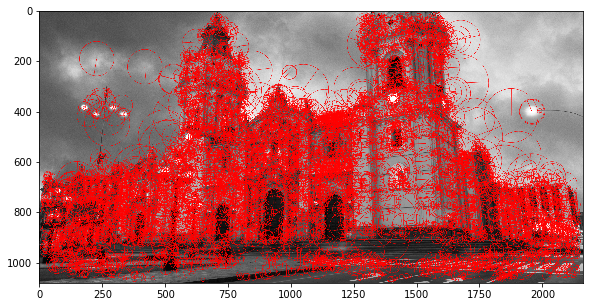

In [29]:
img = cv2.imread('IGLESIA.png',0)

surf = cv2.xfeatures2d.SURF_create(400)
#surf = cv2.SURF(400)

kp, des = surf.detectAndCompute(img,None)

img2 = cv2.drawKeypoints(img,kp,None,(255,0,0),4)

plt.imshow(img2)
plt.show()

Total Keypoints without nonmaxSuppression:  122251


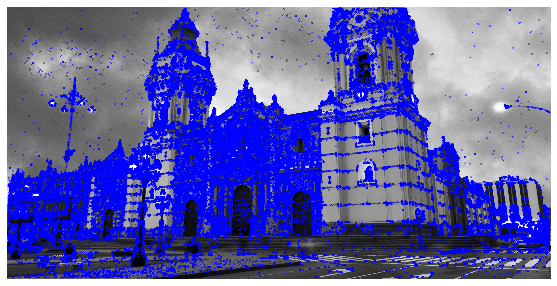

In [39]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('IGLESIA.png',0)

# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()

# find and draw the keypoints
kp = fast.detect(img,None)
img2 = cv2.drawKeypoints(img, kp, None,color=(255,0,0))


cv2.imwrite('fast_true.png',img2)

# Disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)

print ("Total Keypoints without nonmaxSuppression: ", len(kp))

img3 = cv2.drawKeypoints(img, kp,None, color=(255,0,0))

cv2.imwrite('fast_false.png',img3)

img = plt.imread('fast_false.png')
plt.imshow(img)
plt.axis('off')

plt.show()
